In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")

In [9]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = data.shape[1]
    columns = data.columns
    df = pd.DataFrame(data)
    
    df_new = pd.DataFrame()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        for j in range(n_vars):
            df_new['var%d(t-%d)' % (j+1, i)] = df.shift(i)[columns[j]]
   
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        
        for j in range(n_vars):
            if i == 0:
                name = 'var%d(t)' % (j+1)
            else:
                name = 'var%d(t+%d)' % (j+1, i)
            df_new[name] = df.shift(-i)[columns[j]]
    
    if dropnan:
        df_new.dropna(inplace=True)
    return df_new

In [3]:
house_data = pd.read_excel("Clean_Data.xlsx")
house_data

,Date,Time,DateTime,System Setting,System Mode,Calendar Event,Program Mode,Cool Set Temp (C),Heat Set Temp (C),Current Temp (C),...,Thermostat Humidity (%RH),Thermostat Motion,Bedroom (C),Bedroom2,3rd floor landing (C),3rd floor landing2,3rd floor room (C),3rd floor room2,Basement (C),Basement2
0,2020-12-10,12:50:00,2020/12/10 12:50:00,heat,heatOff,auto,Home,21.0,21.0,21.3,...,30.0,1.0,21.6,0.0,20.9,0.0,21.0,0.0,22.8,0.0
1,2020-12-10,12:55:00,2020/12/10 12:55:00,heat,heatOff,auto,Home,21.0,21.0,21.1,...,32.0,1.0,21.6,0.0,20.9,0.0,20.9,0.0,22.7,1.0
2,2020-12-10,13:00:00,2020/12/10 13:00:00,heat,heatOff,auto,Home,21.0,21.0,20.9,...,32.0,0.0,21.6,0.0,20.8,0.0,20.8,0.0,22.7,1.0
3,2020-12-10,13:05:00,2020/12/10 13:05:00,heat,heatOff,auto,Home,21.0,21.0,20.7,...,33.0,0.0,21.6,0.0,20.8,0.0,20.8,0.0,22.8,0.0
4,2020-12-10,13:10:00,2020/12/10 13:10:00,heat,heatStage1On,auto,Home,21.0,21.0,20.6,...,33.0,1.0,21.6,0.0,20.8,0.0,20.8,0.0,22.8,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,2021-03-23,14:25:00,2021/3/23 14:25:00,heat,heatOff,NaN,Home,21.0,21.0,21.2,...,21.0,0.0,21.9,0.0,21.8,0.0,21.3,0.0,22.0,1.0
29672,2021-03-23,14:30:00,2021/3/23 14:30:00,heat,heatOff,NaN,Home,21.0,21.0,21.1,...,21.0,0.0,21.9,0.0,21.8,0.0,21.3,0.0,22.1,0.0
29673,2021-03-23,14:35:00,2021/3/23 14:35:00,heat,heatOff,NaN,Home,21.0,21.0,21.1,...,21.0,0.0,21.9,0.0,21.8,1.0,21.3,0.0,22.1,0.0
29674,2021-03-23,14:40:00,2021/3/23 14:40:00,heat,heatOff,NaN,Home,21.0,21.0,21.1,...,21.0,0.0,21.9,0.0,21.8,1.0,21.3,0.0,22.1,0.0


In [4]:
enc = preprocessing.OneHotEncoder()
house_data = house_data.fillna(method = "bfill")
house_data.isnull().sum()

Date                              0
Time                              0
DateTime                          0
System Setting                    0
System Mode                       0
Calendar Event                29548
Program Mode                      0
Cool Set Temp (C)                 0
Heat Set Temp (C)                 0
Current Temp (C)                  0
Current Humidity (%RH)            0
Outdoor Temp (C)                  0
Wind Speed (km/h)                 0
Cool Stage 1 (sec)                0
Heat Stage 1 (sec)                0
Fan (sec)                         0
Thermostat Temperature (C)        0
Thermostat Humidity (%RH)         0
Thermostat Motion                 0
Bedroom (C)                       0
Bedroom2                          0
3rd floor landing (C)             0
3rd floor landing2                0
3rd floor room (C)                0
3rd floor room2                   0
Basement (C)                      0
Basement2                         0
dtype: int64

In [12]:
numerical_vars = ['Heat Set Temp (C)', 'Current Temp (C)', 'Current Humidity (%RH)', 'Outdoor Temp (C)','Thermostat Temperature (C)', 'Thermostat Humidity (%RH)']
sc = StandardScaler()
sc.fit(house_data[numerical_vars])
scalar_data = sc.transform(house_data[numerical_vars])

In [13]:
y_auxHeat = house_data['Heat Stage 1 (sec)'].to_numpy()
oe = OrdinalEncoder()
y_auxHeat = oe.fit_transform(y_auxHeat.reshape(-1, 1))

In [14]:
scaler_house_data = house_data[numerical_vars].copy()
scaler_house_data[numerical_vars] = scalar_data
scaler_house_data["Heat Stage 1"] = y_auxHeat

In [26]:
reframed = series_to_supervised(scaler_house_data, 6, 1)
reframed

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var1(t-5),var2(t-5),var3(t-5),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
6,0.0,2.632689,1.422976,1.387394,2.632689,1.422976,0.0,0.0,1.489502,1.930176,...,-0.796872,2.183776,20.0,0.0,-0.225278,2.183776,1.424799,-0.225278,2.183776,20.0
7,0.0,1.489502,1.930176,1.387394,1.489502,1.930176,0.0,0.0,0.346315,1.930176,...,-0.225278,2.183776,20.0,0.0,0.917909,2.183776,1.424799,0.917909,2.183776,3.0
8,0.0,0.346315,1.930176,1.424799,0.346315,1.930176,0.0,0.0,-0.796872,2.183776,...,0.917909,2.183776,3.0,0.0,1.489502,2.183776,1.462204,1.489502,2.183776,0.0
9,0.0,-0.796872,2.183776,1.424799,-0.796872,2.183776,9.0,0.0,-1.368465,2.183776,...,1.489502,2.183776,0.0,0.0,1.489502,2.183776,1.462204,1.489502,2.183776,0.0
10,0.0,-1.368465,2.183776,1.424799,-1.368465,2.183776,20.0,0.0,-0.796872,2.183776,...,1.489502,2.183776,0.0,0.0,0.917909,2.183776,1.462204,0.917909,2.183776,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,2.061095,-0.859425,0.0,0.0,2.061095,-0.859425,3.295068,2.061095,-0.859425,0.0
29672,0.0,3.204282,-0.098625,3.295068,3.204282,-0.098625,0.0,0.0,2.632689,-0.605825,...,2.061095,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29673,0.0,2.632689,-0.605825,3.295068,2.632689,-0.605825,0.0,0.0,2.632689,-0.605825,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0
29674,0.0,2.632689,-0.605825,3.295068,2.632689,-0.605825,0.0,0.0,2.061095,-0.605825,...,1.489502,-0.859425,0.0,0.0,1.489502,-0.859425,3.388582,1.489502,-0.859425,0.0


In [24]:
weather_data = pd.read_excel("WeatherData(1).xlsx")
weather_data

,Unnamed: 0,Air Temp,Atmos_Pres,Wetness,Rel_Humidity,Solar_Rad,Wind_Dir,Wind_Speed
0,2020-12-10 12:50:00,4.376,991.65,8.24,78.8,48.1,303.2,0.00
1,2020-12-10 12:55:00,4.272,991.75,8.82,78.9,60.6,304.7,0.00
2,2020-12-10 13:00:00,4.298,991.55,8.82,79.4,108.1,308.9,0.00
3,2020-12-10 13:05:00,4.428,991.75,8.82,79.0,115.6,311.7,0.00
4,2020-12-10 13:10:00,4.454,991.95,8.82,79.2,119.4,263.9,0.00
...,...,...,...,...,...,...,...,...
29677,2021-03-23 14:25:00,16.725,992.15,0.00,26.0,471.9,168.5,2.52
29678,2021-03-23 14:30:00,17.011,992.25,0.00,25.3,425.6,174.1,2.52
29679,2021-03-23 14:35:00,16.725,992.15,0.00,25.4,506.9,148.8,3.02
29680,2021-03-23 14:40:00,16.796,992.15,0.00,25.4,360.6,161.5,2.01


In [53]:
sc = StandardScaler()
sc.fit(weather_data[["Air Temp","Atmos_Pres","Wetness","Rel_Humidity","Solar_Rad","Wind_Dir","Wind_Speed"]])
weather_scalar_data = sc.transform(weather_data[["Air Temp","Atmos_Pres","Wetness","Rel_Humidity","Solar_Rad","Wind_Dir","Wind_Speed"]])
weather_scalar_data = pd.DataFrame(weather_scalar_data)
weather_scalar_data.columns = ["Air Temp","Atmos_Pres","Wetness","Rel_Humidity","Solar_Rad","Wind_Dir","Wind_Speed"]
weather_scalar_data

,Air Temp,Atmos_Pres,Wetness,Rel_Humidity,Solar_Rad,Wind_Dir,Wind_Speed
0,1.201504,0.099141,-0.872215,0.056498,-0.249896,0.713867,-0.857137
1,1.183855,0.110594,-0.859391,0.062935,-0.175408,0.727331,-0.857137
2,1.188268,0.087688,-0.859391,0.095121,0.107644,0.765030,-0.857137
3,1.210329,0.110594,-0.859391,0.069372,0.152337,0.790163,-0.857137
4,1.214741,0.133501,-0.859391,0.082247,0.174981,0.361112,-0.857137
...,...,...,...,...,...,...,...
29677,3.297132,0.156407,-1.054407,-3.342304,2.275528,-0.495196,1.452381
29678,3.345667,0.167860,-1.054407,-3.387364,1.999626,-0.444930,1.452381
29679,3.297132,0.156407,-1.054407,-3.380927,2.484093,-0.672022,1.910618
29680,3.309181,0.156407,-1.054407,-3.380927,1.612291,-0.558028,0.984978


In [55]:
new_data= pd.concat([reframed, weather_scalar_data], axis=1,join_axes=[reframed.index])

new_data.dropna(axis = 0,how="any")

,var1(t-6),var2(t-6),var3(t-6),var4(t-6),var5(t-6),var6(t-6),var7(t-6),var1(t-5),var2(t-5),var3(t-5),...,var5(t),var6(t),var7(t),Air Temp,Atmos_Pres,Wetness,Rel_Humidity,Solar_Rad,Wind_Dir,Wind_Speed
6,0.0,2.632689,1.422976,1.387394,2.632689,1.422976,0.0,0.0,1.489502,1.930176,...,-0.225278,2.183776,20.0,1.214741,0.110594,-0.859391,0.056498,0.152337,0.588204,-0.857137
7,0.0,1.489502,1.930176,1.387394,1.489502,1.930176,0.0,0.0,0.346315,1.930176,...,0.917909,2.183776,3.0,1.219153,0.133501,-0.859391,0.062935,0.055801,0.802729,-0.857137
8,0.0,0.346315,1.930176,1.424799,0.346315,1.930176,0.0,0.0,-0.796872,2.183776,...,1.489502,2.183776,0.0,1.223565,0.110594,-0.859391,0.062935,0.100493,0.335979,-0.857137
9,0.0,-0.796872,2.183776,1.424799,-0.796872,2.183776,9.0,0.0,-1.368465,2.183776,...,1.489502,2.183776,0.0,1.219153,0.110594,-0.872215,0.062935,-0.190306,0.739898,-0.857137
10,0.0,-1.368465,2.183776,1.424799,-1.368465,2.183776,20.0,0.0,-0.796872,2.183776,...,0.917909,2.183776,0.0,1.192680,0.099141,-0.859391,0.075810,-0.137867,0.928393,-0.857137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29671,0.0,3.204282,-0.098625,3.238960,3.204282,-0.098625,0.0,0.0,3.204282,-0.098625,...,2.061095,-0.859425,0.0,3.325472,0.190767,-1.054407,-3.393801,2.618170,-0.457497,1.452381
29672,0.0,3.204282,-0.098625,3.295068,3.204282,-0.098625,0.0,0.0,2.632689,-0.605825,...,1.489502,-0.859425,0.0,3.406250,0.190767,-1.054407,-3.451735,3.154480,-0.457497,1.452381
29673,0.0,2.632689,-0.605825,3.295068,2.632689,-0.605825,0.0,0.0,2.632689,-0.605825,...,1.489502,-0.859425,0.0,3.345667,0.179314,-1.054407,-3.400238,1.843501,-0.797686,1.452381
29674,0.0,2.632689,-0.605825,3.295068,2.632689,-0.605825,0.0,0.0,2.061095,-0.605825,...,1.489502,-0.859425,0.0,3.333448,0.202220,-1.054407,-3.387364,1.478214,-0.609191,1.910618


In [56]:
X = new_data.drop(labels = ['var7(t)'], axis = 1)

In [57]:
y_auxHeat = new_data['var7(t)']
y_auxHeat = to_categorical(y_auxHeat)

In [58]:
X_train = X.iloc[:23736,]
y_train = y_auxHeat[:23736,]
X_test = X.iloc[23736:]
y_test = y_auxHeat[23736:]

In [59]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 55))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 64, epochs = 50, shuffle = True)

Epoch 1/50
371/371 [==============================] - 1s 2ms/step - loss: 1.4529 - accuracy: 0.6837 - val_loss: 0.8038 - val_accuracy: 0.8015
Epoch 2/50
371/371 [==============================] - 1s 2ms/step - loss: 0.9918 - accuracy: 0.7323 - val_loss: 0.7707 - val_accuracy: 0.8042
Epoch 3/50
371/371 [==============================] - 1s 2ms/step - loss: 0.9341 - accuracy: 0.7353 - val_loss: 0.7274 - val_accuracy: 0.8074
Epoch 4/50
371/371 [==============================] - 1s 3ms/step - loss: 0.9033 - accuracy: 0.7383 - val_loss: 0.7102 - val_accuracy: 0.8094
Epoch 5/50
371/371 [==============================] - 2s 4ms/step - loss: 0.8822 - accuracy: 0.7390 - val_loss: 0.7087 - val_accuracy: 0.8082
Epoch 6/50
371/371 [==============================] - 1s 3ms/step - loss: 0.8685 - accuracy: 0.7393 - val_loss: 0.6924 - val_accuracy: 0.8099
Epoch 7/50
371/371 [==============================] - 1s 2ms/step - loss: 0.8557 - accuracy: 0.7419 - val_loss: 0.6826 - val_accuracy: 0.8116
Epoch 

In [60]:
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 24)                1344      
_________________________________________________________________
dense_7 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_8 (Dense)              (None, 21)                525       
Total params: 2,469
Trainable params: 2,469
Non-trainable params: 0
_________________________________________________________________


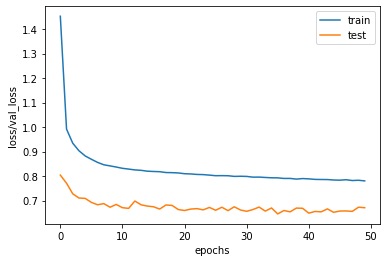

In [61]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss/val_loss")
plt.savefig("Weather1.png")
plt.show()

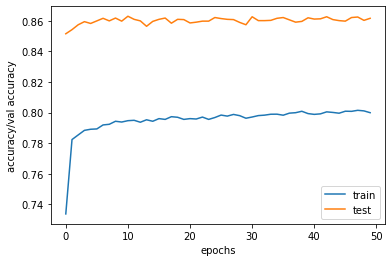

In [89]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.xlabel("epochs")
plt.ylabel("accuracy/val accuracy")
plt.savefig("Weather2.png")
plt.show()

In [63]:
y_predicted = classifier.predict(X_test)

In [64]:
y_predicted = np.argmax(y_predicted, axis = 1)
y_predicted

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [65]:
y_test = np.argmax(y_test, axis = 1)

In [66]:
test_sum = y_test.sum()*15
test_sum

460770

In [67]:
predicted_sum = y_predicted.sum()*15

In [68]:
predicted_sum

451470

In [69]:
print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))

Error Percentage in predicted values is : 2.018360570349632 %


In [70]:
from sklearn.metrics import mean_absolute_error,f1_score,accuracy_score

In [71]:
y_train_predicted = classifier.predict(X_train)
y_train_predicted = np.argmax(y_train_predicted, axis = 1)
y_train = np.argmax(y_train, axis = 1)

In [72]:
f1_score(y_train, y_train_predicted, average = 'weighted')

0.707860740683621

In [81]:
accuracy_score(y_train, y_train_predicted)

0.851937984496124

In [74]:
mean_absolute_error(y_train, y_train_predicted)

1.0116279069767442

In [75]:
mean_absolute_error(y_test, y_predicted)

0.9504550050556118

In [83]:
accuracy_score(y_test, y_predicted)

0.8615942028985508

In [77]:
f1_score(y_test, y_predicted, average = 'weighted')

0.7827957041446236